In [2]:
from openpyxl import load_workbook
import numpy as np
import sklearn
import pandas as pd
from pandas import DataFrame
from itertools import islice

audio_wb = load_workbook('choiby_file_final2.xlsx')
sheet = audio_wb['split']


####### XLS to Pandas DataFrame 
data = sheet.values
cols = next(data)[1:]
data = list(data)
idx = [r[0] for r in data]
data = (islice(r, 1, None) for r in data)
df = DataFrame(data, index=idx, columns=cols)

gene_1 = df[df["gene_type"]==0]
gene_2 = df[df["gene_type"]==1]
print(len(gene_1), len(gene_2))
#42, 56
#31:11, 42,14
#print(gene_1[1:2])



42 56


In [12]:
#### dB divide by 10 ####
cols = ["rt_250","rt_500","rt_1k","rt_2k","rt_3k","rt_4k","rt_8k"]
gene_1[cols] /= 100
gene_2[cols] /= 100
n_cols = len(cols) #이것이 input x값이 된다.

##### Random Assign #########
n_seed = 10  #random함수 일정하게 고정

#31:11, 42:14 로 두 gene을 나누어 구성한다.
gene_1_rnd = sklearn.utils.shuffle(gene_1,random_state=n_seed)
gene_2_rnd = sklearn.utils.shuffle(gene_2,random_state=n_seed)

gene_train = pd.concat([gene_1_rnd[:31], gene_2_rnd[:42]])
gene_test = pd.concat([gene_1_rnd[31:],gene_2_rnd[42:]])

print(len(gene_train),len(gene_test))


#### Pandas DataFrame to List ####
x_train = gene_train[cols].values
x_test = gene_test[cols].values
y_train_f = gene_train["gene_type"].values
y_test_f = gene_test["gene_type"].values

#gene_1[1:5,"rt_250"] /= 100
#gene_1[cols] /= 100
#gene_1
print(len(x_train),len(x_test),len(y_train),len(y_test))

C:\Users\junn\Anaconda3\envs\tf\lib\site-packages\pandas\core\frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


73 25
73 25 73 25


In [13]:
#print(gene_test)
#print(y_test)

def one_hot(a, num_classes):
    print(a, num_classes)
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

y_test = pd.to_numeric(y_test_f, downcast='signed')
y_train = pd.to_numeric(y_train_f, downcast='signed')
y_test = one_hot(y_test,2)
y_train = one_hot(y_train,2)
#print(y_test)

#x_train = np.expand_dims(x_train, axis=2)
#x_train = np.reshape(x_train, (len(x_train), 7, 1))
print(x_train[0])
#x_test = np.reshape(x_test, (len(x_test), 7, 1))

print(y_train[0])
shape = x_train.shape[1]
print(cols)
print(shape)

print(x_train.shape)
print(y_train.shape)

[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 2
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 2
[3.0e-05 4.0e-05 4.0e-05 5.0e-05 5.0e-05 4.5e-05 5.0e-05]
[1. 0.]
['rt_250', 'rt_500', 'rt_1k', 'rt_2k', 'rt_3k', 'rt_4k', 'rt_8k']
7
(73, 7)
(73, 2)


In [14]:
# RNN 
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Dense, Activation, SpatialDropout1D, Dropout
from keras.layers.recurrent import LSTM
from keras import models, layers
from keras import metrics, callbacks

class LossHistory(callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

history = LossHistory() # 손실 이력 객체 생성
history.init()

num_epochs = 1000
N_BATCH = 14
N_HIDDEN = 10

print(x_train.shape)

model = Sequential()

### Test1 : LSTM
#model.add(LSTM(64, input_shape = (n_cols, 1), dropout=0.4, recurrent_dropout=0.4))

### Test2 : Simple
#model.add(Dense(10, input_shape=(n_cols,), activation="relu"))
#model.add(Dense(10, activation="softmax"))

model.add(Dense(2, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history2 = model.fit(x_train, y_train, epochs=num_epochs, 
                    validation_data=(x_test, y_test),
                    batch_size=N_BATCH, verbose=2, shuffle=False)



(73, 7)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 10)                80        
_________________________________________________________________
dense_8 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 22        
Total params: 212
Trainable params: 212
Non-trainable params: 0
_________________________________________________________________
Train on 73 samples, validate on 25 samples
Epoch 1/1000
 - 3s - loss: 0.6928 - acc: 0.5753 - val_loss: 0.6916 - val_acc: 0.5600
Epoch 2/1000
 - 0s - loss: 0.6911 - acc: 0.5753 - val_loss: 0.6914 - val_acc: 0.5600
Epoch 3/1000
 - 0s - loss: 0.6904 - acc: 0.5753 - val_loss: 0.6911 - val_acc: 0.5600
Epoch 4/1000
 - 0s - loss: 0.6899 - acc: 0.5753 - val_loss: 0.6908 - val_acc: 0.5600
Epoch 5/1000
 - 

Epoch 88/1000
 - 0s - loss: 0.6825 - acc: 0.5753 - val_loss: 0.6885 - val_acc: 0.5600
Epoch 89/1000
 - 0s - loss: 0.6826 - acc: 0.5753 - val_loss: 0.6886 - val_acc: 0.5600
Epoch 90/1000
 - 0s - loss: 0.6826 - acc: 0.5753 - val_loss: 0.6887 - val_acc: 0.5600
Epoch 91/1000
 - 0s - loss: 0.6827 - acc: 0.5753 - val_loss: 0.6888 - val_acc: 0.5600
Epoch 92/1000
 - 0s - loss: 0.6827 - acc: 0.5753 - val_loss: 0.6888 - val_acc: 0.5600
Epoch 93/1000
 - 0s - loss: 0.6828 - acc: 0.5753 - val_loss: 0.6889 - val_acc: 0.5600
Epoch 94/1000
 - 0s - loss: 0.6828 - acc: 0.5753 - val_loss: 0.6890 - val_acc: 0.5600
Epoch 95/1000
 - 0s - loss: 0.6829 - acc: 0.5753 - val_loss: 0.6891 - val_acc: 0.5600
Epoch 96/1000
 - 0s - loss: 0.6829 - acc: 0.5753 - val_loss: 0.6891 - val_acc: 0.5600
Epoch 97/1000
 - 0s - loss: 0.6830 - acc: 0.5753 - val_loss: 0.6892 - val_acc: 0.5600
Epoch 98/1000
 - 0s - loss: 0.6830 - acc: 0.5753 - val_loss: 0.6893 - val_acc: 0.5600
Epoch 99/1000
 - 0s - loss: 0.6831 - acc: 0.5753 - val

Epoch 183/1000
 - 0s - loss: 0.6864 - acc: 0.5753 - val_loss: 0.6939 - val_acc: 0.5600
Epoch 184/1000
 - 0s - loss: 0.6864 - acc: 0.5753 - val_loss: 0.6940 - val_acc: 0.5600
Epoch 185/1000
 - 0s - loss: 0.6864 - acc: 0.5753 - val_loss: 0.6940 - val_acc: 0.5600
Epoch 186/1000
 - 0s - loss: 0.6865 - acc: 0.5753 - val_loss: 0.6940 - val_acc: 0.5600
Epoch 187/1000
 - 0s - loss: 0.6865 - acc: 0.5753 - val_loss: 0.6941 - val_acc: 0.5600
Epoch 188/1000
 - 0s - loss: 0.6865 - acc: 0.5753 - val_loss: 0.6941 - val_acc: 0.5600
Epoch 189/1000
 - 0s - loss: 0.6865 - acc: 0.5753 - val_loss: 0.6941 - val_acc: 0.5600
Epoch 190/1000
 - 0s - loss: 0.6866 - acc: 0.5753 - val_loss: 0.6941 - val_acc: 0.5600
Epoch 191/1000
 - 0s - loss: 0.6866 - acc: 0.5753 - val_loss: 0.6942 - val_acc: 0.5600
Epoch 192/1000
 - 0s - loss: 0.6866 - acc: 0.5753 - val_loss: 0.6942 - val_acc: 0.5600
Epoch 193/1000
 - 0s - loss: 0.6866 - acc: 0.5753 - val_loss: 0.6942 - val_acc: 0.5600
Epoch 194/1000
 - 0s - loss: 0.6867 - acc: 

 - 0s - loss: 0.6879 - acc: 0.5753 - val_loss: 0.6958 - val_acc: 0.5600
Epoch 278/1000
 - 0s - loss: 0.6879 - acc: 0.5753 - val_loss: 0.6958 - val_acc: 0.5600
Epoch 279/1000
 - 0s - loss: 0.6879 - acc: 0.5753 - val_loss: 0.6958 - val_acc: 0.5600
Epoch 280/1000
 - 0s - loss: 0.6879 - acc: 0.5753 - val_loss: 0.6958 - val_acc: 0.5600
Epoch 281/1000
 - 0s - loss: 0.6879 - acc: 0.5753 - val_loss: 0.6958 - val_acc: 0.5600
Epoch 282/1000
 - 0s - loss: 0.6879 - acc: 0.5753 - val_loss: 0.6959 - val_acc: 0.5600
Epoch 283/1000
 - 0s - loss: 0.6879 - acc: 0.5753 - val_loss: 0.6959 - val_acc: 0.5600
Epoch 284/1000
 - 0s - loss: 0.6879 - acc: 0.5753 - val_loss: 0.6959 - val_acc: 0.5600
Epoch 285/1000
 - 0s - loss: 0.6879 - acc: 0.5753 - val_loss: 0.6959 - val_acc: 0.5600
Epoch 286/1000
 - 0s - loss: 0.6880 - acc: 0.5753 - val_loss: 0.6959 - val_acc: 0.5600
Epoch 287/1000
 - 0s - loss: 0.6880 - acc: 0.5753 - val_loss: 0.6959 - val_acc: 0.5600
Epoch 288/1000
 - 0s - loss: 0.6880 - acc: 0.5753 - val_lo

Epoch 372/1000
 - 0s - loss: 0.6883 - acc: 0.5753 - val_loss: 0.6963 - val_acc: 0.5600
Epoch 373/1000
 - 0s - loss: 0.6883 - acc: 0.5753 - val_loss: 0.6963 - val_acc: 0.5600
Epoch 374/1000
 - 0s - loss: 0.6883 - acc: 0.5753 - val_loss: 0.6964 - val_acc: 0.5600
Epoch 375/1000
 - 0s - loss: 0.6883 - acc: 0.5753 - val_loss: 0.6964 - val_acc: 0.5600
Epoch 376/1000
 - 0s - loss: 0.6883 - acc: 0.5753 - val_loss: 0.6964 - val_acc: 0.5600
Epoch 377/1000
 - 0s - loss: 0.6883 - acc: 0.5753 - val_loss: 0.6964 - val_acc: 0.5600
Epoch 378/1000
 - 0s - loss: 0.6883 - acc: 0.5753 - val_loss: 0.6964 - val_acc: 0.5600
Epoch 379/1000
 - 0s - loss: 0.6883 - acc: 0.5753 - val_loss: 0.6964 - val_acc: 0.5600
Epoch 380/1000
 - 0s - loss: 0.6883 - acc: 0.5753 - val_loss: 0.6964 - val_acc: 0.5600
Epoch 381/1000
 - 0s - loss: 0.6883 - acc: 0.5753 - val_loss: 0.6964 - val_acc: 0.5600
Epoch 382/1000
 - 0s - loss: 0.6883 - acc: 0.5753 - val_loss: 0.6964 - val_acc: 0.5600
Epoch 383/1000
 - 0s - loss: 0.6883 - acc: 

Epoch 467/1000
 - 0s - loss: 0.6884 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 468/1000
 - 0s - loss: 0.6884 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 469/1000
 - 0s - loss: 0.6884 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 470/1000
 - 0s - loss: 0.6884 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 471/1000
 - 0s - loss: 0.6884 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 472/1000
 - 0s - loss: 0.6884 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 473/1000
 - 0s - loss: 0.6884 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 474/1000
 - 0s - loss: 0.6884 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 475/1000
 - 0s - loss: 0.6884 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 476/1000
 - 0s - loss: 0.6884 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 477/1000
 - 0s - loss: 0.6884 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 478/1000
 - 0s - loss: 0.6884 - acc: 

Epoch 562/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 563/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 564/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 565/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 566/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 567/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 568/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 569/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 570/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 571/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 572/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 573/1000
 - 0s - loss: 0.6885 - acc: 

 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 657/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 658/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 659/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 660/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 661/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 662/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 663/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 664/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 665/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 666/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 667/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_lo

Epoch 751/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 752/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 753/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 754/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 755/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 756/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 757/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 758/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 759/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 760/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 761/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 762/1000
 - 0s - loss: 0.6885 - acc: 

Epoch 846/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 847/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 848/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 849/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 850/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 851/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 852/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 853/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 854/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 855/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 856/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 857/1000
 - 0s - loss: 0.6885 - acc: 

Epoch 941/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 942/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 943/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 944/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 945/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 946/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 947/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 948/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 949/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 950/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 951/1000
 - 0s - loss: 0.6885 - acc: 0.5753 - val_loss: 0.6965 - val_acc: 0.5600
Epoch 952/1000
 - 0s - loss: 0.6885 - acc: 

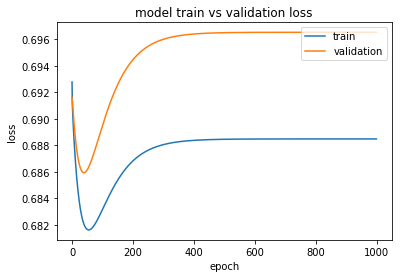

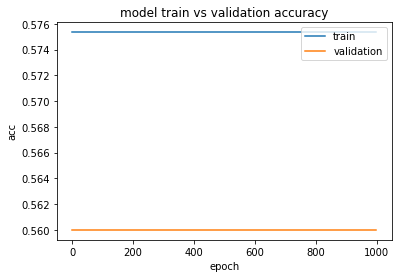

In [15]:
# Soft 돌린 결과 

# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as pyplot

pyplot.plot(history2.history['loss'])
pyplot.plot(history2.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

pyplot.plot(history2.history['acc'])
pyplot.plot(history2.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('acc')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

#plt.plot(history.losses)
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['train'], loc='upper left')
#plt.show()


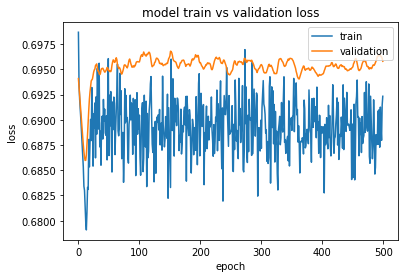

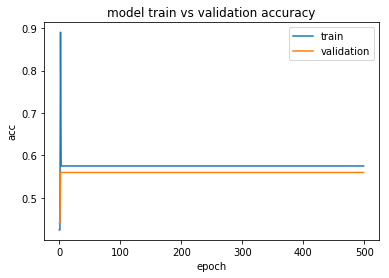

In [46]:
# LSTM 돌린 결과 

# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as pyplot

pyplot.plot(history2.history['loss'])
pyplot.plot(history2.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

pyplot.plot(history2.history['acc'])
pyplot.plot(history2.history['val_acc'])
pyplot.title('model train vs validation accuracy')
pyplot.ylabel('acc')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

#plt.plot(history.losses)
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['train'], loc='upper left')
#plt.show()


In [43]:
# 7. 모델 평가하기
scores = model.evaluate(x_train, y_train)
print("Train %s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

scores = model.evaluate(x_test, y_test)
print("Test %s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

73/73 [==============================] - 0s 587us/step
Train acc: 57.53%
25/25 [==============================] - 0s 399us/step
Test acc: 56.00%


In [44]:
#print(x_test[0])
for i in range(0,len(x_test)):
    s = x_test[i] 
    out = model.predict([[s]])
    print(out,np.argmax(out),np.argmax(y_test[i]))

[[0.36911133 0.6308887 ]] 1 0
[[0.36930865 0.6306914 ]] 1 0
[[0.3690421 0.6309579]] 1 0
[[0.3692213 0.6307787]] 1 0
[[0.3690421 0.6309579]] 1 0
[[0.36901537 0.63098466]] 1 0
[[0.36904204 0.630958  ]] 1 0
[[0.3689796 0.6310204]] 1 0
[[0.369142   0.63085794]] 1 0
[[0.36912727 0.6308728 ]] 1 0
[[0.36905143 0.6309486 ]] 1 0
[[0.36906782 0.63093215]] 1 1
[[0.3690795 0.6309205]] 1 1
[[0.36916438 0.6308356 ]] 1 1
[[0.3691392 0.6308608]] 1 1
[[0.36899564 0.63100433]] 1 1
[[0.36898026 0.6310197 ]] 1 1
[[0.36895567 0.63104427]] 1 1
[[0.3690224 0.6309776]] 1 1
[[0.36896574 0.63103426]] 1 1
[[0.36905193 0.630948  ]] 1 1
[[0.36892357 0.63107646]] 1 1
[[0.36883402 0.631166  ]] 1 1
[[0.3689668 0.6310332]] 1 1
[[0.36895016 0.6310499 ]] 1 1
